# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [5]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error as mse

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [6]:
#Load your data into a pandas dataframe here
df = pd.read_csv('../aai530-assignment3/data-assignment2.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [7]:
#convert datetime to epoch/unix time
df['unix'] = df['Datetime'].astype('int64') // 10**9

In [8]:
df.head()

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,Date,Time,30_day_MA_GAP,30_day_MA_GRP,30_day_MA_GI,30_day_MA_SM1,unix
0,0,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,2006-12-16,17:24:00,4.21600,0.41800,18.40000,0.00000,1166289840
1,1,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,2006-12-16,17:25:00,4.78800,0.42700,20.70000,0.00000,1166289900
2,2,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,2006-12-16,17:26:00,4.98333,0.45067,21.46667,0.00000,1166289960
3,3,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,2006-12-16,17:27:00,5.08450,0.46350,21.85000,0.00000,1166290020
4,4,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,2006-12-16,17:28:00,4.80080,0.47640,20.64000,0.00000,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the for prediction horizon and mu is the forgetting factor. 

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [38]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 60*5 #5 minutes
ph_index = ph // 60 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The first data point will have about 0.9^4999 ~= 0 weight on the last prediction. 

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [46]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index - 1: ph_index - 1+i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]
    yp = m_tmp*tp + q_tmp 
      
    tp_pred[i-2] = tp + ph
    yp_pred[i-2] = yp.item()

Now let's visualize the results from our model.

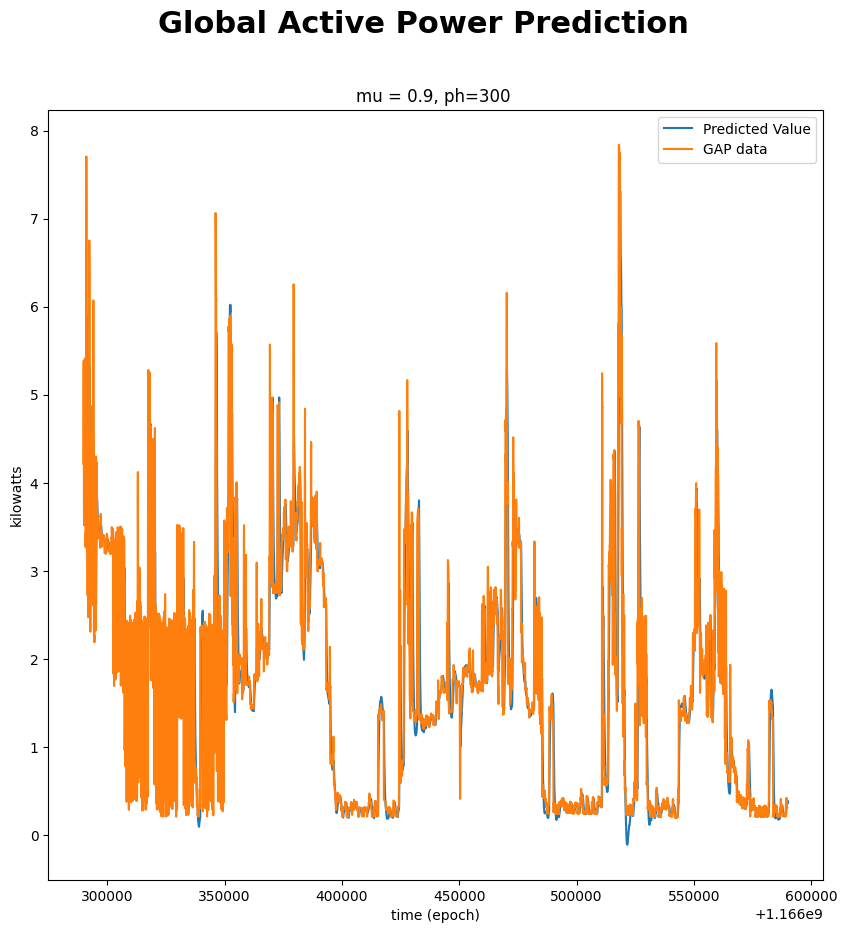

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

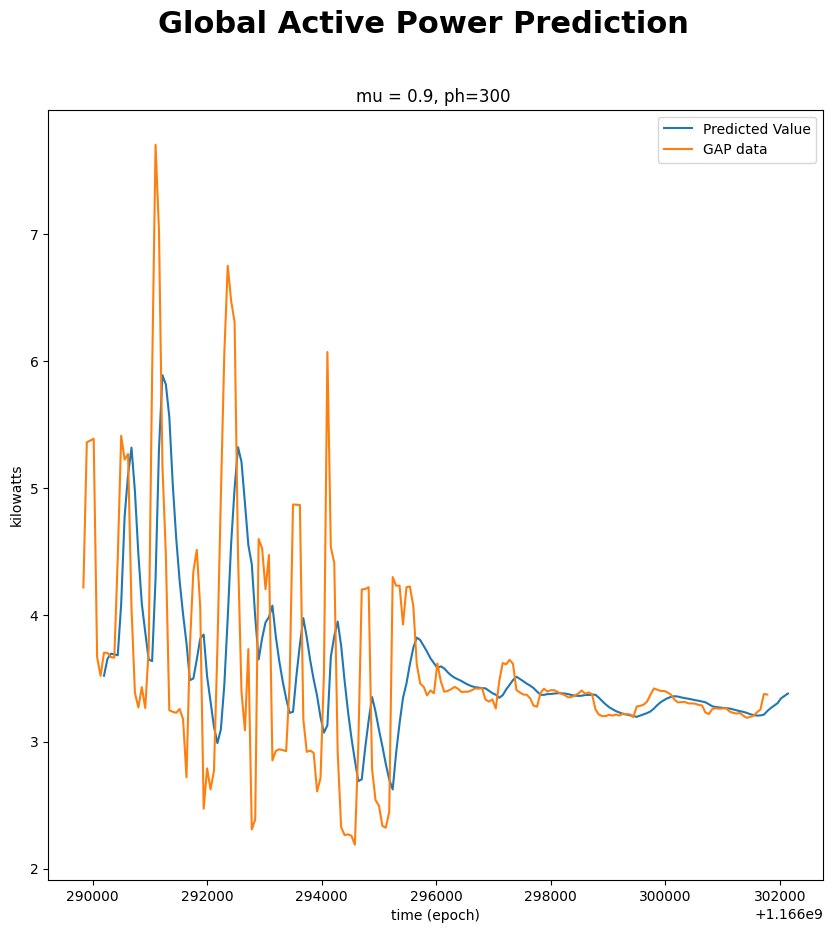

In [31]:
#Plot first 200 data points/predictions    
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

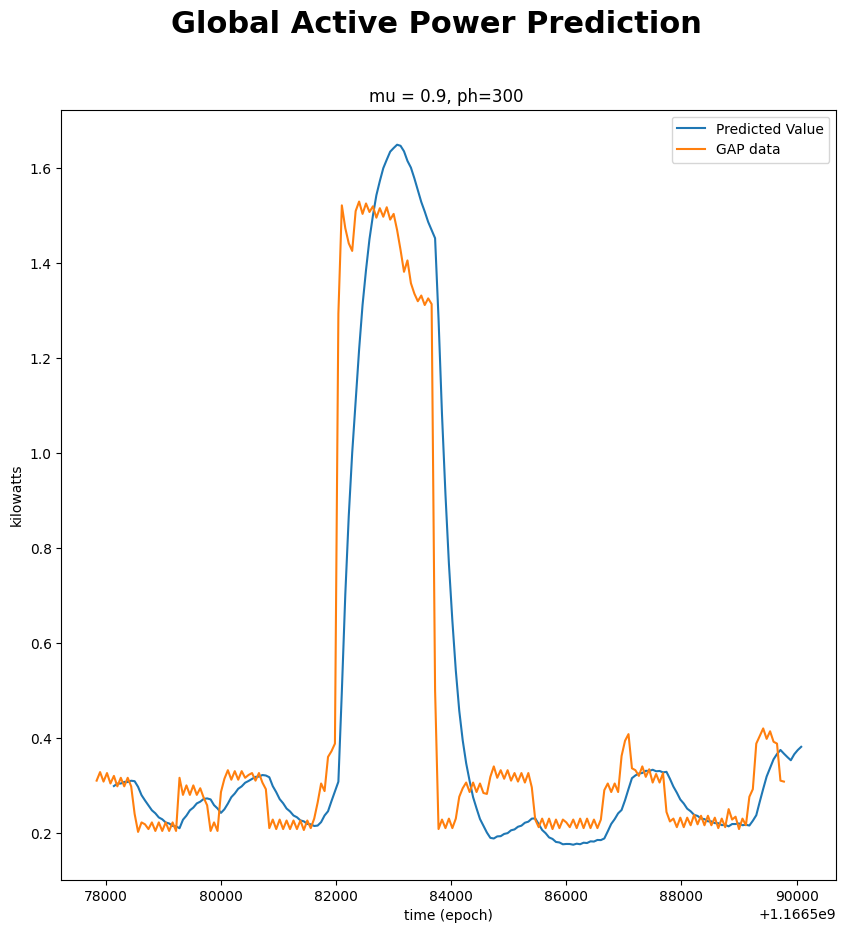

In [35]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [24]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.22791531507073842


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model performed decently, but not great. Based on the charts it looks like the model is delayed from the changes that happen in the real data, which makes sense. The earlier predictions look worse visually but also are a lot more volitial making it harder for a linear regression model to predict. The MSE is pretty good but in the context of the values that GAP can be (ranging from 0 to abtout 7), it is not as impressive as it would if the values were somewhere closer to 250 like in the lab.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [40]:
#Re-run prediction code for mu = 1
mu = 1

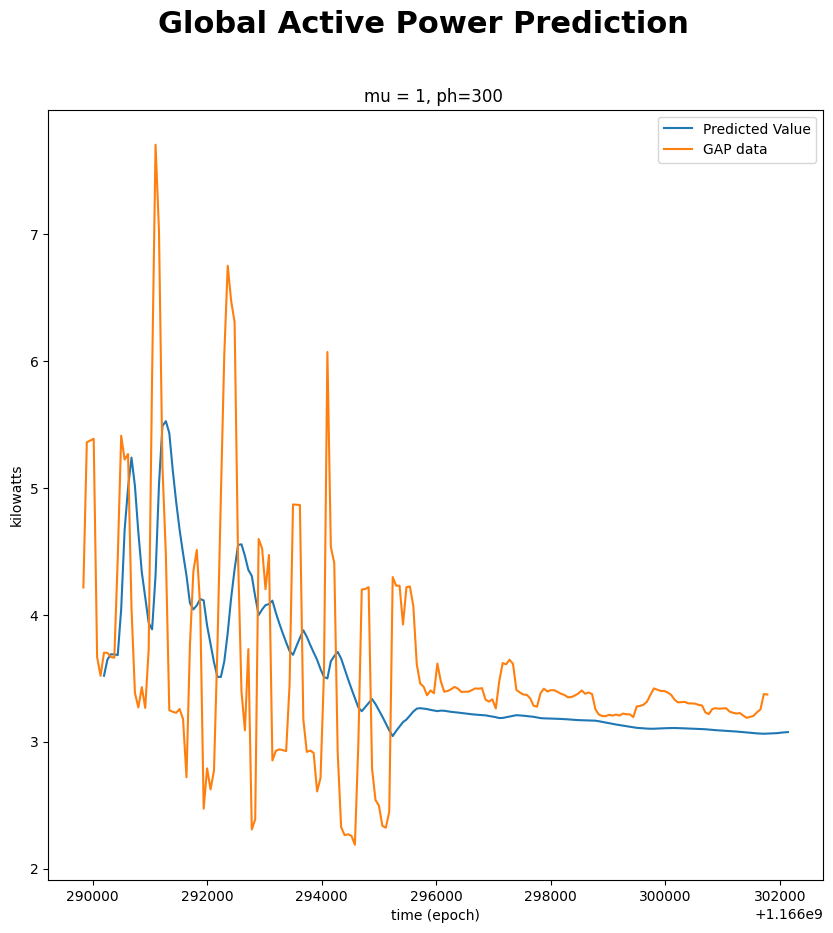

In [42]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

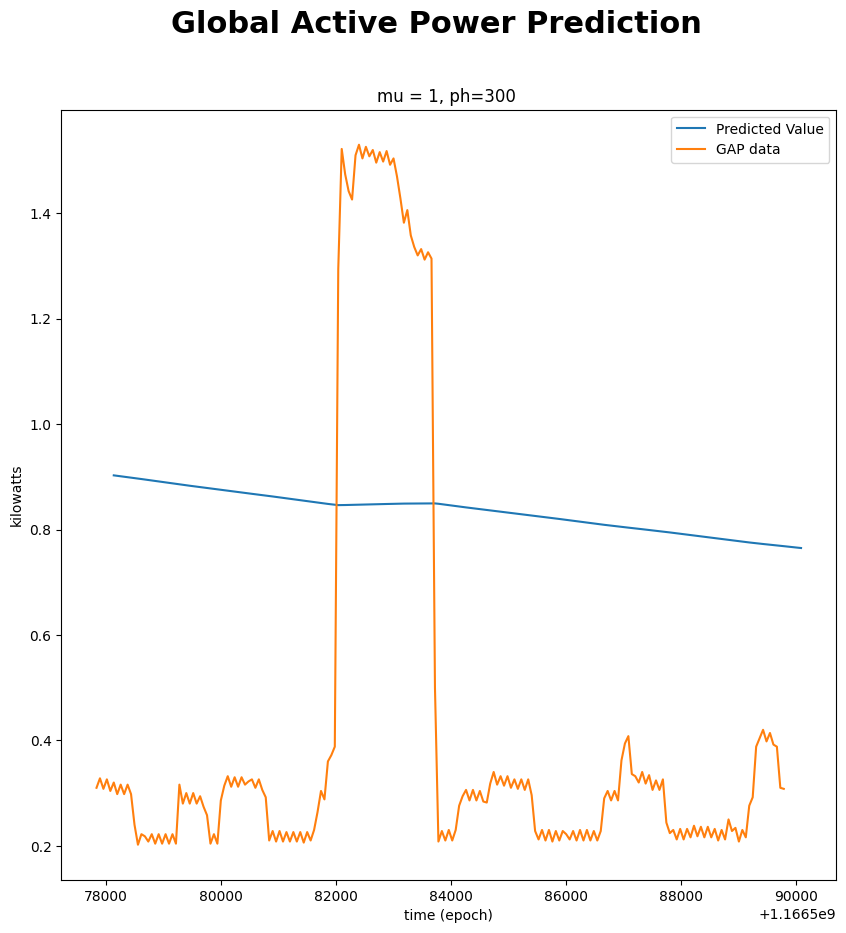

In [43]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [44]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3798272100021023


In [45]:
#Re-run prediction code for mu = 0.01
mu = 0.01

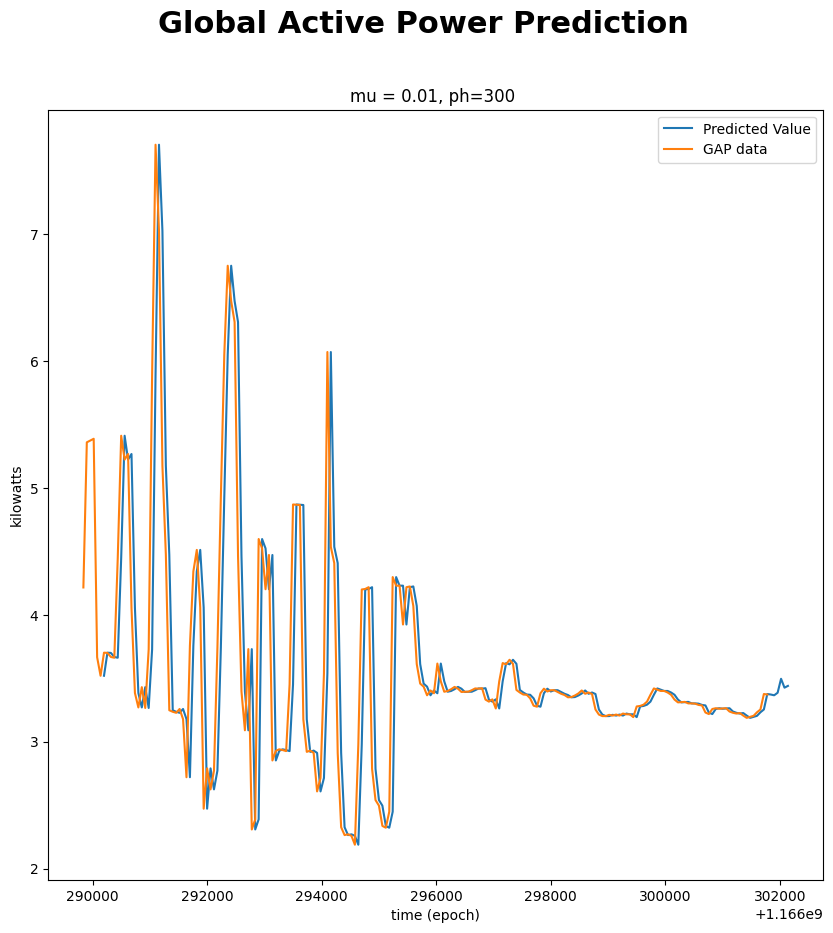

In [47]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

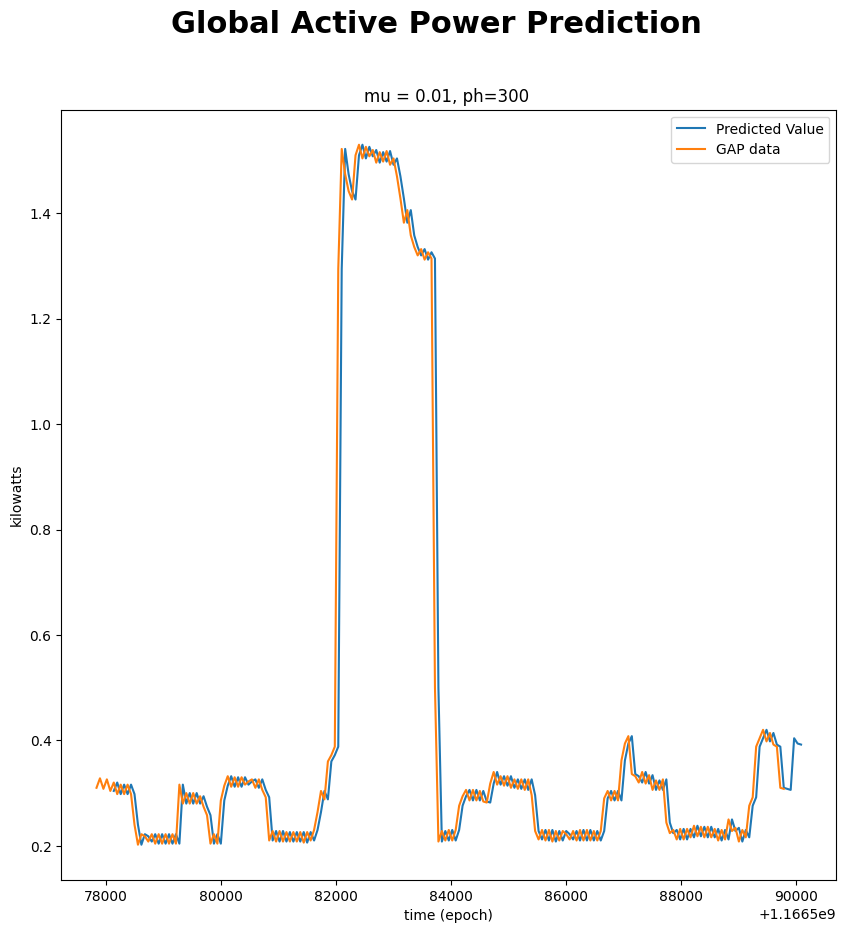

In [48]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [49]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 5.085009468311812e-09


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model performed worse than our original baseline of 0.9, especially when you consider the end of the dataset. This makes sense because when predicting the end the forgetting factor is still weighting past values strongly and not forgetting them. The visualizations in this experiment really show that as the later predictions are given there is less change overall, almost converging on a single value. The MSE confirms what we are seeing with it being about 1.22 meaning it is much worse than our baseline. 

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The forgetting factor of 0.01 performs really well. The charts show that the predictions almost completely follow the real data. There is little to no change between the first chart and the end chart since the model is basically only weighting a few values each time it makes a prediction. The MSE also confirms that this model performed much better than the previous two as its value is closer to 0.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The model that performed the best was the last one that has a mu of 0.01. The reason this can be considered as the 'best' is because it has the lowest MSE. This makes sense because with a smaller mu value the linear regression model is very heavily weighting most recent data points and since this data is very volitile that makes it better at predicting those quicker changes. 

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Depending on your sytem the usefulness of different mu values is weighted differently, in general we probably want to find a balance between a very low mu value that places high importance on recent data and a mu value that takes into acount historical data. For GPA a user may want to keep more historical data to look out for anomolize or be able to predict when a system might spike. It also could be more realistic and useful we may want to start considering things beyond mu values such as adding more variables or using a different model other than linear regression. 

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [19]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'unix': df.unix,    # time series data
    'voltage': df.Voltage  # voltage data
})
ys = pd.DataFrame(df.Global_active_power)

ph = 60*5 #5 minutes
ph_index = ph // 60 
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [24]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i] # unix and voltage
    ys_tmp = ys[ph_index - 1: ph_index - 1+i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]
    yp = m_tmp[0][0] * tp + m_tmp[0][1] * ts.iloc[i-1,1] + q_tmp  # adjusted for both unix and voltage
      
    tp_pred[i-2] = tp + ph
    yp_pred[i-2] = yp.item()

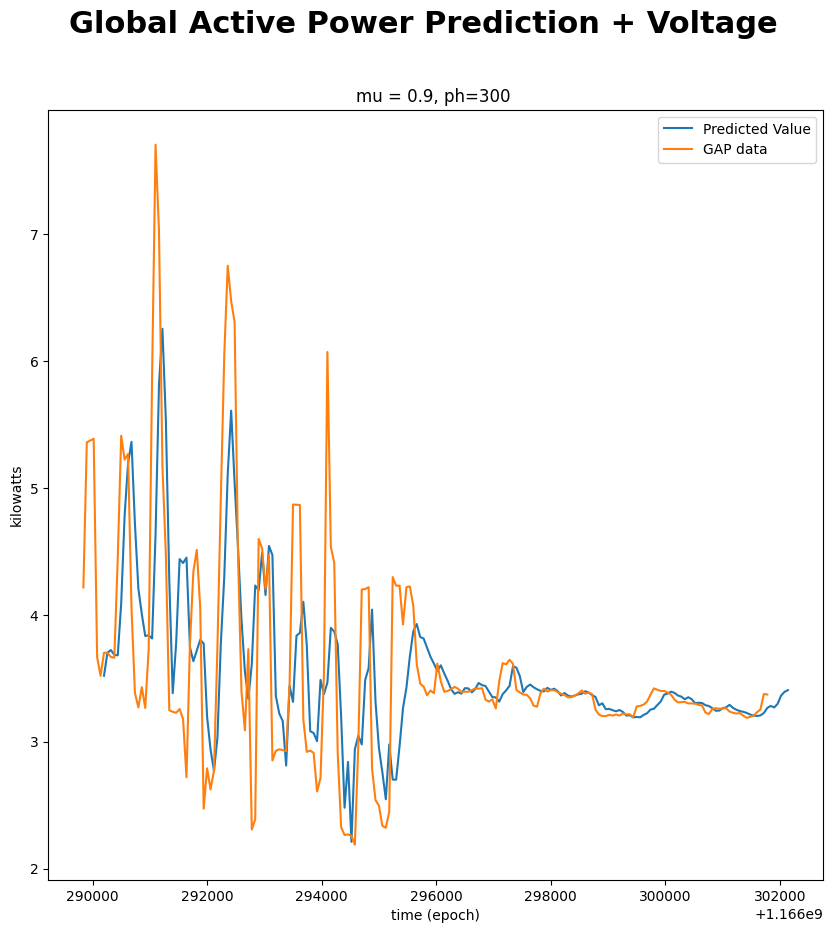

In [29]:
#Plot first 200 data points/predictions for the expanded dataset

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction + Voltage', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

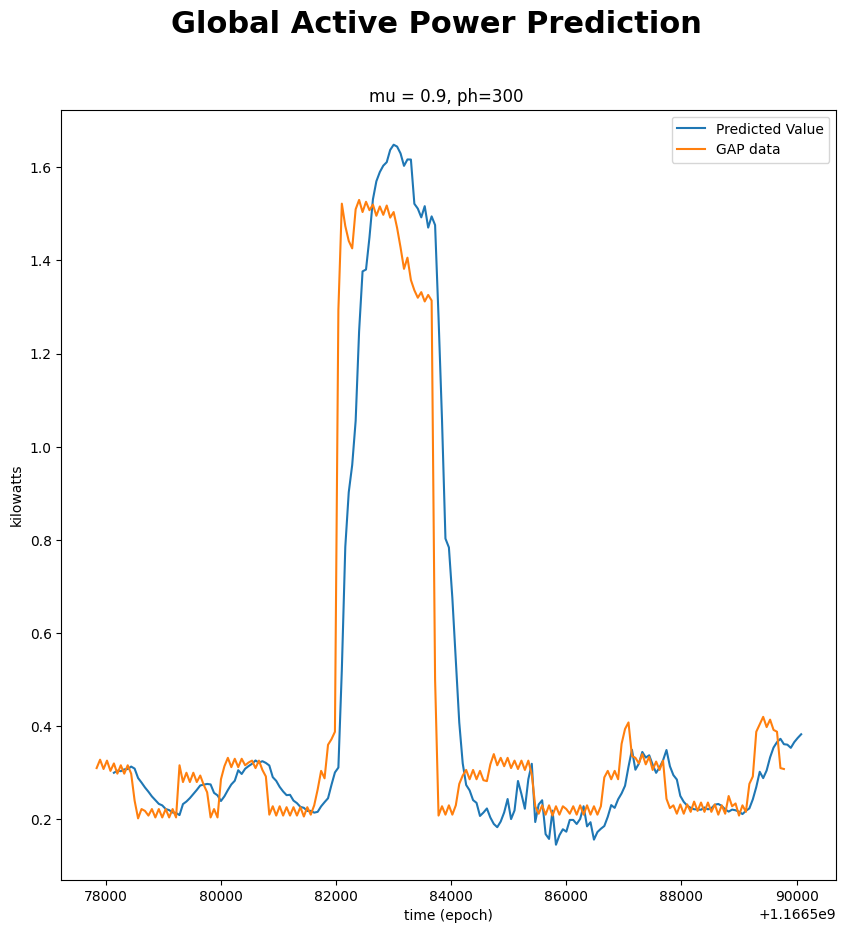

In [30]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [31]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.1822405915840544


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model with the voltage data did slightly better than the one without that added data. It seems to do a better job in predicting small changes. For example in the first baseline model the values near the last 200 predictions have a spike but the spike with the added voltage data is more reflective of the real data. 

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I am going to choose to use a moving average as the response variable. This will hopefully improve the model because it will smooth the data over time and help reduce the noise in the raw data. Moving averages can also help stabalize the model if there are hgih peaks in the original data. I could perform a couple experiments with what scale to use for cacluating the rolling average andn since the data is suppose to have a predictive horizon of 5 I chose to keep the rolling average smaller. 

In [64]:
#create your alternative training data here
scale = 20
ts = pd.DataFrame({
    'unix': df['unix'][scale:].reset_index(drop=True),    # Time series data (unix time)
    'voltage': df['Voltage'][scale:].reset_index(drop=True)  # Voltage data
})
ys = df['Global_active_power'].rolling(window=scale).mean()
ys = ys[scale:].reset_index(drop=True)

ph = 60 * 5 #5 minutes
ph_index = ph // 60 
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [65]:
#re-run the prediction code here

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i] # unix and voltage
    ys_tmp = ys[ph_index - 1: ph_index - 1+i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]
    yp = m_tmp[0] * tp + m_tmp[1] * ts.iloc[i-1,1] + q_tmp  # adjusted for both unix and voltage
      
    tp_pred[i-2] = tp + ph
    yp_pred[i-2] = yp.item()

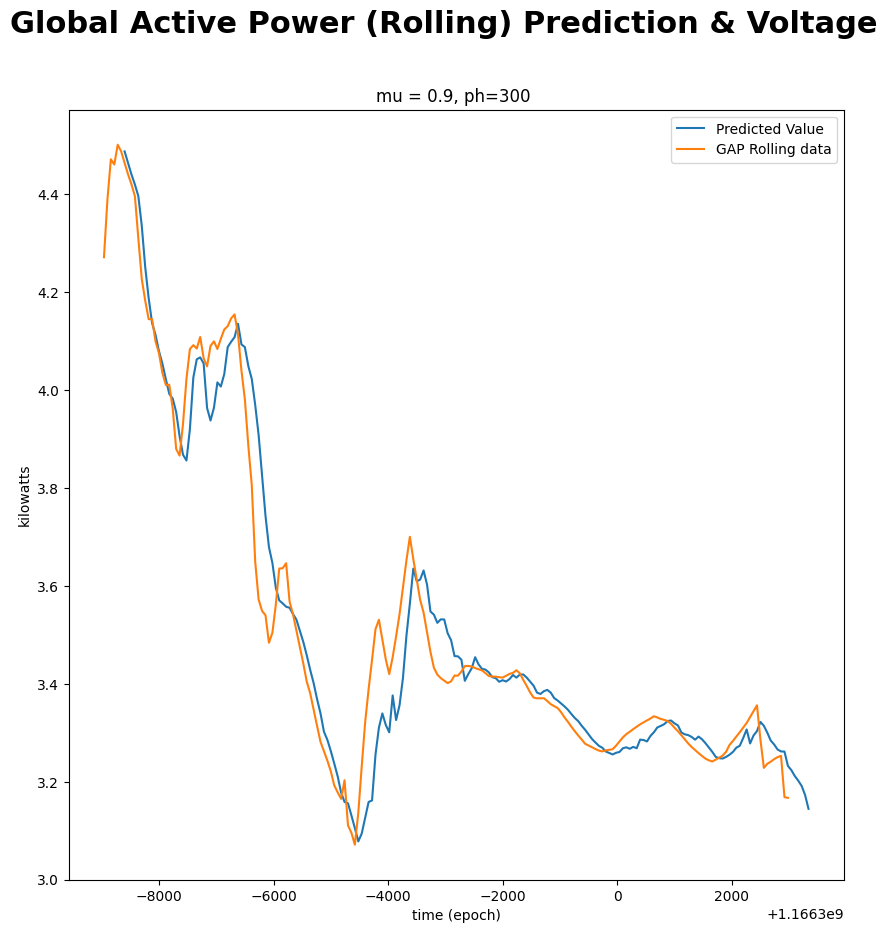

In [66]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power (Rolling) Prediction & Voltage', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200], label='GAP Rolling data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

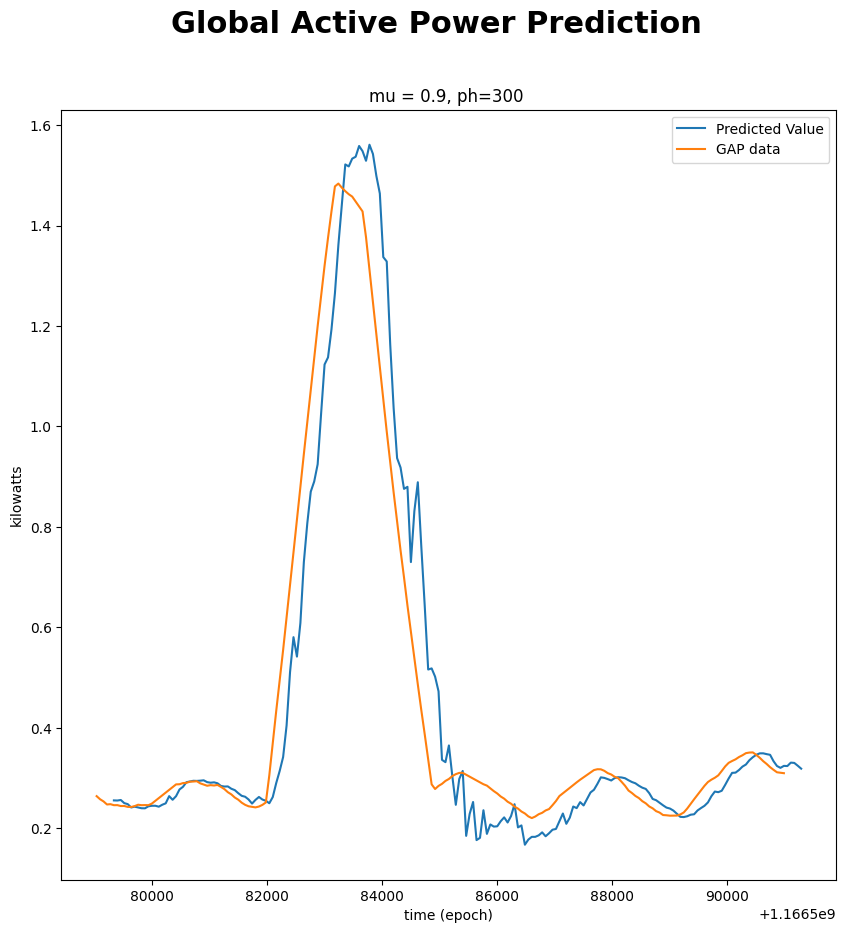

In [67]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [68]:
#Calculate MSE of predictions for alternative model
print("MSE is", mse(ys[ph_index:5000+ph_index-1],yp_pred))

MSE is 0.02322704421241442


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The alternative model improved the previous results when compared against the model that also included voltage, since this last alternative model keep the additional variable. To continue to improve this we could experiment with better scales for the rolling average, we could also implement a dynamic mu factor, or use a different predictive model. 

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.